##################### End-to-end project by Patrick Mthisi (patrickmthisi@hotmail.com ###################################

# CREDIT CARD FRAUD DETECTION:
 
 Data for the project was sourced from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.
 
Project context: "It is important that credit card companies are able to recognise fraudulent credit card transactions so that customers are not charged for items they did not purchase." kaggle.
 
Content: "The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification." kaggle.

Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project


# 0. OBJECTIVES: 

In this project, we investigated a suite of weighted machine learning methods that are commonly used to address skewed class distributions. Also investigated are data sampling approaches to address class imbalance. The following aspects are addressed in this project:
- Exploring the credit card dataset using a automated data profiling module.
- Data cleaning using a custom VIF() module to address multicollinearity.
- Framing the fraud detection problem, developing a test harness and evaluating the baseline model. 
- Exploring a set of weighted machine learning algorithms and ensembles.
- Exploring a suite of data sampling methods to address class imbalance.
- Determining the optimal threshold based on Fbeta-score:
   - applies more weight to recall to limit false negatives, i.e., actual fraud cases predicted as non-fraud., and
   - beta in the fbeta-measures can be increased to values beta > 2.
- Finalising and potential improvements.

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from collections import Counter
from scipy.spatial.distance import mahalanobis
from ydata_profiling import ProfileReport
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [2]:
filename = 'creditcard.csv'
credit_dta = pd.read_csv(filename)
print(credit_dta.shape)
target = credit_dta['Class'].values
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(284807, 31)
Class=0, Count=284315, Percentage=99.827%
Class=1, Count=492, Percentage=0.173%


In [3]:
credit_data_profile = ProfileReport(credit_dta)
credit_data_profile.to_file("credit_data_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
def column_mapping(df):
    c_map = [f"{c[0]}:{c[1]}" for c in enumerate(df.columns)]
    return c_map

# define a module that calculate VIF and remove features with VIF greater than threshold (typically set to 5)
class VIF(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 5):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        '''
        Parameters:
        X: pandas dataframe 
        
        returns:
        X-cleaned: pandas DataFrame
            DataFrame with variables that has VIF less than the threshold.

        '''
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        self.X = X.copy()
        df = pd.DataFrame()
        # calculate VIF for each variable in the dataframe
        df['VIF factor'] = [variance_inflation_factor(self.X.values,  i) for i in range(self.X.shape[1])]
        df['features'] = self.X.columns
        print('VIF Calculation')
        print(30*'--')
        print(df)
        high_vif_cols = df['features'][df['VIF factor'] > self.threshold].to_list()
        # drop columns where vif greater threshold
        X_cleaned = self.X[self.X.columns.difference(high_vif_cols)]
        return X_cleaned

# Data cleaning

In [4]:
column_mapping(credit_dta)

['0:Time',
 '1:V1',
 '2:V2',
 '3:V3',
 '4:V4',
 '5:V5',
 '6:V6',
 '7:V7',
 '8:V8',
 '9:V9',
 '10:V10',
 '11:V11',
 '12:V12',
 '13:V13',
 '14:V14',
 '15:V15',
 '16:V16',
 '17:V17',
 '18:V18',
 '19:V19',
 '20:V20',
 '21:V21',
 '22:V22',
 '23:V23',
 '24:V24',
 '25:V25',
 '26:V26',
 '27:V27',
 '28:V28',
 '29:Amount',
 '30:Class']

In [5]:
# drop duplicates
credit_dta.drop_duplicates(inplace=True) 
# Scale 'Amount' column 
amount_scaled = StandardScaler().fit_transform(credit_dta['Amount'].values.reshape(-1, 1))
credit_dta['Amount'] = amount_scaled

# drop time variable
credit_dta.drop(columns='Time', axis=1, inplace=True)

# Check the shape of the resulting DataFrame
print(credit_dta.shape)

(283726, 30)


In [6]:
# select feature columns
features = credit_dta.iloc[:,:-1]
credit_dta_clean = VIF().fit_transform(features)
credit_dta_clean['Class'] = credit_dta['Class'].values

VIF Calculation
------------------------------------------------------------
    VIF factor features
0     1.633300       V1
1     4.466644       V2
2     1.542252       V3
3     1.121091       V4
4     2.816734       V5
5     1.572236       V6
6     2.907436       V7
7     1.131087       V8
8     1.024156       V9
9     1.123990      V10
10    1.000245      V11
11    1.001702      V12
12    1.000372      V13
13    1.014246      V14
14    1.000101      V15
15    1.000656      V16
16    1.001508      V17
17    1.015783      V18
18    1.038426      V19
19    2.403369      V20
20    1.135968      V21
21    1.052271      V22
22    1.159593      V23
23    1.000351      V24
24    1.028632      V25
25    1.000168      V26
26    1.011014      V27
27    1.001595      V28
28   12.295352   Amount


In [8]:
credit_data_clean_profile = ProfileReport(credit_dta_clean)
credit_data_clean_profile.to_file("credit_data_clean_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Evaluate base model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, roc_curve
#  load the dataset
def get_data(data, target):
    df = data.copy()
    X = df[df.columns.difference([target])].values
    y = df[target].values 
    # label encode target to class 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y


def evaluate_model(X, y, model):
    # split data into trainn/test sets
    TrainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
    # train model
    model.fit(TrainX, trainy)
    # predict
    yhat = model.predict_proba(testX)
    model_probs = yhat[:, 1]
     # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    pr_auc = auc(recall, precision)
    # compute roc auc
    roc_auc = roc_auc_score(testy, model_probs, labels=[0, 1])
    fpr, tpr, _ = roc_curve(testy, model_probs)
    
    return pr_auc, roc_auc, precision, recall, fpr, tpr

# load the dataset
X, y = get_data(credit_dta_clean, 'Class')
# summarise the loaded data
print(X.shape, y.shape, Counter(y))
# define baseline model
model = DummyClassifier(strategy='stratified')
# evaluate model
pr_score, auc_score, precision, recall, fpr, tpr = evaluate_model(X, y, model)
# summarise performance
print('%s PR AUC: %.3f , ROC AUC: %.3f ' %  ('Baseline', pr_score, auc_score))

(283726, 28) (283726,) Counter({0: 283253, 1: 473})
Baseline PR AUC: 0.008 , ROC AUC: 0.503 


# Evaluate a suite of weighted machine learning algorithms and ensembles

In [34]:
# import machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier


# define voting ensemble model
def get_voting():
    # define base models
    models = list()
    models.append(('lr', LogisticRegression(solver='liblinear', class_weight='balanced')))
    models.append(('cart', CalibratedClassifierCV(DecisionTreeClassifier(class_weight='balanced'), method='sigmoid', cv=3)))
    models.append(('svm', CalibratedClassifierCV(SVC(gamma='scale', class_weight='balanced', probability=True), method='sigmoid' , cv=3)))
    models.append(('rf', CalibratedClassifierCV(RandomForestClassifier(class_weight='balanced'), method='sigmoid', cv=3)))
    models.append(('xgb', XGBClassifier(scale_pos_weight=600)))
    # define voting ensemble
    voting_ensemble = VotingClassifier(estimators=models, voting='soft')
    return voting_ensemble

# define stacking ensemble
def get_stacking():
    # define level0 models
    level0 = list()
    level0.append(('lr', LogisticRegression(solver='liblinear', class_weight='balanced')))
    level0.append(('cart', DecisionTreeClassifier(class_weight='balanced')))
    level0.append(('svm', SVC(gamma='scale', class_weight='balanced')))
    level0.append(('rf', RandomForestClassifier(class_weight='balanced')))
    level0.append(('xgb', XGBClassifier(scale_pos_weight=600)))
    # define level1 model
    leve1 = LogisticRegression()
    # define stacking ensemble
    stacking_ensemble = StackingClassifier(estimators=level0, final_estimator=leve1, cv=5)
    return stacking_ensemble

# define models to test
def get_models():
    models = dict()
    models['lr'] = make_pipeline(PowerTransformer(), LogisticRegression(solver='liblinear', class_weight='balanced'))
    models['svm'] = CalibratedClassifierCV(SVC(gamma='scale', class_weight='balanced', probability=True))
    models['cart'] = CalibratedClassifierCV(DecisionTreeClassifier(class_weight='balanced'), method='sigmoid', cv=3)
    models['rf'] = CalibratedClassifierCV(RandomForestClassifier(class_weight='balanced'), method='sigmoid', cv=3)
    models['xgb'] = XGBClassifier(scale_pos_weight=600)
    models['voting'] = get_voting()
    models['stacking'] = get_stacking()
    return models

# get models
models = get_models()
for name, model in models.items():
    pr_score, auc_score, precision, recall, fpr, tpr = evaluate_model(X, y, model)
    print('%s PR AUC: %.3f , ROC AUC: %.3f ' %  (name, pr_score, auc_score))

lr PR AUC: 0.711 , ROC AUC: 0.973 
svm PR AUC: 0.496 , ROC AUC: 0.969 
cart PR AUC: 0.801 , ROC AUC: 0.891 
rf PR AUC: 0.806 , ROC AUC: 0.947 
xgb PR AUC: 0.812 , ROC AUC: 0.964 
voting PR AUC: 0.794 , ROC AUC: 0.974 
stacking PR AUC: 0.793 , ROC AUC: 0.974 


# Handling class imbalance using data sampling

In [35]:
# implementing data sampling strategies
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek

# define data sampling models
def get_models():
    models = dict()
    models['smote'] = SMOTE()
    models['borderline'] = BorderlineSMOTE()
    models['svmsmote'] = SVMSMOTE()
    models['adasyn'] = ADASYN()
    models['smoteenn'] = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    models['smotetomek'] = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    return models

# define voting ensemble model
def get_voting():
    # define base models
    models = list()
    models.append(('lr', LogisticRegression(solver='liblinear')))
    models.append(('cart', CalibratedClassifierCV(DecisionTreeClassifier(), method='sigmoid', cv=3)))
    models.append(('svm', CalibratedClassifierCV(SVC(gamma='scale', probability=True), method='sigmoid', cv=3)))
    models.append(('rf', CalibratedClassifierCV(RandomForestClassifier(), method='sigmoid', cv=3)))
    models.append(('xgb', XGBClassifier()))
    # define voting ensemble
    voting_ensemble = VotingClassifier(estimators=models, voting='soft')
    return voting_ensemble

# get models
models = get_models()
# define classification model
classifier = get_voting()
# evaluate models
for name, model in models.items():
    steps = list()
    steps.append(('sampling_strategy', model))
    steps.append(('clf', classifier))
    pipeline = Pipeline(steps=steps)
    pr_score, auc_score, precision, recall, fpr, tpr = evaluate_model(X, y, classifier)
    print('%s PR AUC: %.3f , ROC AUC: %.3f' %  (name, pr_score, auc_score))

smote PR AUC: 0.810 , ROC AUC: 0.974
borderline PR AUC: 0.809 , ROC AUC: 0.974
svmsmote PR AUC: 0.808 , ROC AUC: 0.974
adasyn PR AUC: 0.808 , ROC AUC: 0.974
smoteenn PR AUC: 0.809 , ROC AUC: 0.974
smotetomek PR AUC: 0.809 , ROC AUC: 0.974


# Determining the optimal threshold using the best model

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

def get_voting():
    # define base models
    models = list()
    models.append(('lr', LogisticRegression(solver='liblinear')))
    models.append(('cart', CalibratedClassifierCV(DecisionTreeClassifier(), method='sigmoid', cv=3)))
    models.append(('svm', CalibratedClassifierCV(SVC(gamma='scale', probability=True), method='sigmoid', cv=3)))
    models.append(('rf', CalibratedClassifierCV(RandomForestClassifier(), method='sigmoid', cv=3)))
    models.append(('xgb', XGBClassifier()))
    # define voting ensemble
    voting_ensemble = VotingClassifier(estimators=models, voting='soft')
    return voting_ensemble


def evaluate_model(X, y, model):
    # split data into trainn/test sets
    TrainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
    # train model
    model.fit(TrainX, trainy)
    # predict
    yhat = model.predict_proba(testX)
    model_probs = yhat[:, 1]
     # calculate the precision-recall auc
    precision, recall, threshold = precision_recall_curve(testy, model_probs)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(testy, model_probs, labels=[0, 1])
    return pr_auc, roc_auc, precision, recall, threshold

# define classification model
model = get_voting()
# define pipeline
steps = []
steps.append(('sampling_strategy', SMOTE()))
steps.append(('model', model))
pipeline = Pipeline(steps=steps)
# evaluate model
pr_auc, roc_auc, precision, recall, threshold = evaluate_model(X, y, pipeline)

Threshold: 0.55386, Fbeta-score: 0.798


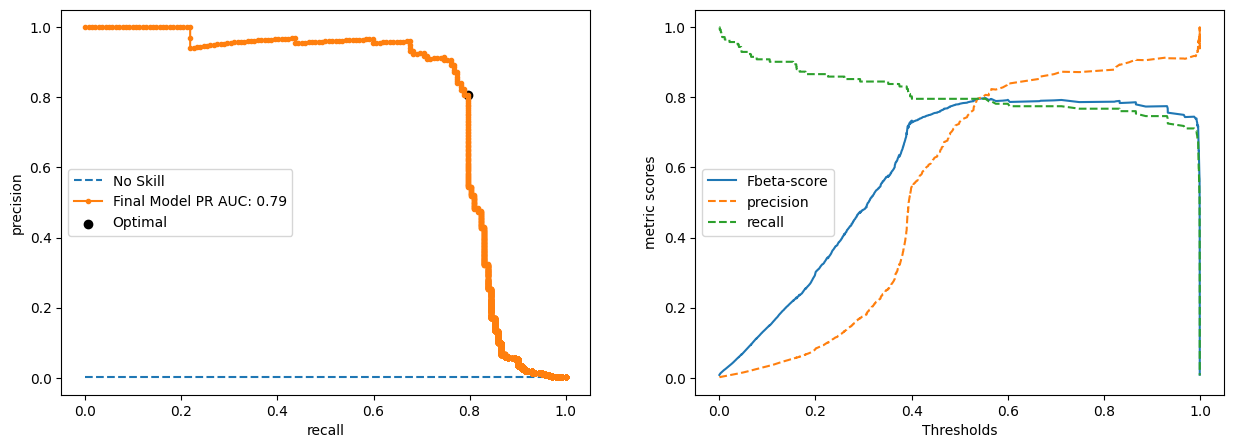

In [23]:
# calculate Fbeta-score and locate the index for maximum Fbeta-score
beta = 2
Fbeta_score = (1+beta**2) * (precision * recall) / (beta**2 * precision + recall)
idx_max = np.argmax(Fbeta_score)
# print the optimal threshold and the corresponding fbeta-score 
print('Threshold: %.5f, Fbeta-score: %.3f' % (threshold[idx_max], Fbeta_score[idx_max]))
# plot pr curve and locate optimal threshold
baseline = Counter(y)[1] / Counter(y)[0]
fig, ax = plt.subplots(figsize=(15,5))
ax.remove()
plt.subplot(1, 2, 1)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label=f"Final Model PR AUC: {pr_auc:.2f}")
plt.scatter(recall[idx_max], precision[idx_max], marker='o', color='black', label='Optimal')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(threshold, Fbeta_score[:-1], label = 'Fbeta-score')
plt.plot(threshold, precision[:-1], label = 'precision', linestyle='--')
plt.plot(threshold, recall[:-1], label = 'recall', linestyle='--')
plt.xlabel('Thresholds')
plt.ylabel('metric scores')
plt.legend()
plt.show()

# Where do we go from here?
- In this highly skewed dataset, the voting ensemble produced the highest performance score, achieving a ROC AUC of 0.974 and a PR AUC of 0.794. Utilizing this model as a baseline, we evaluated various sampling methods, including SMOTE and SMOTETomek, to address the challenges posed by class imbalance. While the ROC AUC remained consistent across the different sampling techniques, SMOTE delivered the most significant improvement in PR AUC, rising to 0.810, an increase from the initial score of 0.794.

- The machine learning algorithms that we employed in this project used default parameters. Performance can be enhanced by employing grid search to determine the best parameters. 

- One can explore one-class algorithms in this work as well. The ones that l can think of are isolation forests or one-class support vector machines. Due to the severe class imbalance, l believe these algorithms could yield very interesting and useful results. 